In [3]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np


df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")


# Country Color Coding
color_code = {
    "Finland": "#003580",  # Blue
    "Sweden": "#FECC02",  # Yellow  # FFDA00 
    "Norway": "#EF2B2D",  # Red
    "Estonia": "#0072CE",  # Blue
    "Denmark": "#C60C30",  # Red
    "Brazil": "#007A33",  # Green
    "France": "#002395",  # Blue
    "Germany": "#FFCC00",  # Black
    "Argentina": "#75AADB",  # Light Blue
    "England": "#D81E05",  # Red
    "Hungary": "#C84E42",  # Red
    "Italy": "#006400",  # Green
    "Bangladesh": "#006A4E",  # Green
    "India": "#FF9933",  # Saffron/Orange
    "South Korea": "#0F64CD",  # Saffron/Orange
    "Mexico": "#006341",  # Saffron/Orange
    "Saudi Arabia": "#165d31",  # Saffron/Orange
    "Egypt": "#C09300", 
    "United States": "#B31942", 
    "Spain": "#AA151B", 
    "Japan": "#BC002D",
    "Azerbaijan": "#0092BC",
    "Greece": "#0D5EAF",
    "Poland": "#DC143C",
    "Portugal": "#046A38",
    "Greece": "#0D5EAF",
    "Turkey": "#C8102E",
    "Wales": "#00B140",
    "Default": "#000000",
    "general_palettes" : ['00afb9', '0081a7', '5fa8d3'],
    "blue_color": '#1f77b4',  
    "orange_color": '#ff7f0e'
}

def get_country_color(country):
    """Helper function to get color for a country"""
    return color_code.get(country, color_code["Default"])

<h1 style="line-height:3rem;">1. Total Matches played by a specific country against specific opponent </h1>

<h3 style="line-height:2rem;">From the following table, we can say that before 1990, more matches had been played, ranging between 7 and 10 every 10 years.
</h3>

<h4 style="line-height:3rem;">Finland played most matches with Sweden compared to other Nordic countries.

</h4>


<h4 style="line-height:2rem;">

Looking at the tables, Finland seems to play better against Norway. Their overall record shows they win about 22% of the time and draw about 33% of their matches.

However, Finland doesn't win as often against Denmark, with only about 9% of those games ending in a win. Against Sweden, their win rate is around 17%.
</h4>

In [38]:
import pandas as pd

def add_year_and_result(df, team_1):
    df['Year'] = pd.to_datetime(df['Date']).dt.year

    def get_result(row):
        if row['Home_team'] == team_1 and row['home_score'] > row['away_score']:
            return "Win"
        elif row['Away_team'] == team_1 and row['away_score'] > row['home_score']:
            return "Win"
        elif row['home_score'] == row['away_score']:
            return "Draw"
        else:
            return "Loss"

    df['Result'] = df.apply(get_result, axis=1)

    # Add Goals Scored & Conceded
    df['Goals Scored'] = df.apply(
        lambda x: x['home_score'] if x['Home_team'] == team_1 else x['away_score'], axis=1)
    df['Goals Conceded'] = df.apply(
        lambda x: x['away_score'] if x['Home_team'] == team_1 else x['home_score'], axis=1)

    return df

def generate_year_interval(df, start_year, end_year, interval):
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()
    df['Year Interval'] = df['Year'].apply(lambda x: f"{(x - start_year) // interval * interval + start_year}-"
                                                    f"{(x - start_year) // interval * interval + start_year + interval - 1}")
    return df

def calculate_match_stats(df, team_1, opponent, interval, start_year, end_year):
    df_filtered = df[
        (((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
         ((df['Home_team'] == opponent) & (df['Away_team'] == team_1)))
    ].copy()

    if df_filtered.empty:
        return pd.DataFrame()

    df_filtered = add_year_and_result(df_filtered, team_1)
    df_filtered = generate_year_interval(df_filtered, start_year, end_year, interval)

    grouped = df_filtered.groupby('Year Interval')

    stats = grouped.agg({
        'Result': lambda x: x.tolist(),
        'Goals Scored': ['sum', 'mean', 'std'],
        'Goals Conceded': ['sum', 'mean', 'std']
    })

    stats.columns = ['Results', 'Goals Scored', 'Avg Goals Scored', 'Std Goals Scored',
                     'Goals Conceded', 'Avg Goals Conceded', 'Std Goals Conceded']
    stats.reset_index(inplace=True)

    stats['Win'] = stats['Results'].apply(lambda x: x.count('Win'))
    stats['Loss'] = stats['Results'].apply(lambda x: x.count('Loss'))
    stats['Draw'] = stats['Results'].apply(lambda x: x.count('Draw'))
    stats['Total Matches'] = stats[['Win', 'Draw', 'Loss']].sum(axis=1)

    stats['Opponent'] = opponent
    stats['Win %'] = (stats['Win'] / stats['Total Matches'] * 100).round(2)
    stats['Loss %'] = (stats['Loss'] / stats['Total Matches'] * 100).round(2)
    stats['Draw %'] = (stats['Draw'] / stats['Total Matches'] * 100).round(2)

    return stats[[
        'Year Interval', 'Opponent', 'Total Matches', 'Win', 'Loss', 'Draw',
        'Goals Scored', 'Goals Conceded', 'Avg Goals Scored', 'Avg Goals Conceded',
        'Std Goals Scored', 'Std Goals Conceded',
        'Win %', 'Loss %', 'Draw %'
    ]]

def match_result_analysis(df, team_1, opponents, interval, start_year, end_year):
    all_results = []
    for opponent in opponents:
        stats = calculate_match_stats(df, team_1, opponent, interval, start_year, end_year)
        if not stats.empty:
            all_results.append(stats)
    return pd.concat(all_results, ignore_index=True)

def display_results_table(results_df, team_1):
    opponents = results_df['Opponent'].unique()

    for opponent in opponents:
        print(f"\n {team_1} --- {opponent} ---")

        sub_df = results_df[results_df['Opponent'] == opponent].copy()

        # TOTAL row
        total_row = {
            "Year Interval": "TOTAL",
            "Opponent": opponent,
            "Total Matches": sub_df['Total Matches'].sum(),
            "Win": sub_df['Win'].sum(),
            "Loss": sub_df['Loss'].sum(),
            "Draw": sub_df['Draw'].sum(),
            "Goals Scored": sub_df['Goals Scored'].sum(),
            "Goals Conceded": sub_df['Goals Conceded'].sum(),
            "Avg Goals Scored": sub_df['Goals Scored'].sum() / sub_df['Total Matches'].sum(),
            "Avg Goals Conceded": sub_df['Goals Conceded'].sum() / sub_df['Total Matches'].sum(),
            "Std Goals Scored": df.loc[
                (((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
                 ((df['Home_team'] == opponent) & (df['Away_team'] == team_1))),
                'Goals Scored'].std(),
            "Std Goals Conceded": df.loc[
                (((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
                 ((df['Home_team'] == opponent) & (df['Away_team'] == team_1))),
                'Goals Conceded'].std(),
        }

        total_row["Win %"] = round((total_row["Win"] / total_row["Total Matches"]) * 100, 2)
        total_row["Loss %"] = round((total_row["Loss"] / total_row["Total Matches"]) * 100, 2)
        total_row["Draw %"] = round((total_row["Draw"] / total_row["Total Matches"]) * 100, 2)

        total_df = pd.DataFrame([total_row])
        combined_df = pd.concat([sub_df, total_df], ignore_index=True)

        styled = combined_df.style.background_gradient(
            subset=["Total Matches", "Win", "Loss", "Draw", "Goals Scored", "Goals Conceded",
                    "Avg Goals Scored", "Avg Goals Conceded",
                    "Std Goals Scored", "Std Goals Conceded",
                    "Win %", "Loss %", "Draw %"],
            cmap='Blues'
        ).set_properties(**{'text-align': 'center'}).set_table_styles(
            [dict(selector='th', props=[('text-align', 'center')])]
        )

        display(styled)

def run_team_analysis(df, team_1, opponents, interval=10, start_year=1960, end_year=2024):
    df = add_year_and_result(df, team_1)
    results_df = match_result_analysis(df, team_1, opponents, interval, start_year, end_year)

    if results_df.empty:
        print("No match data found for the specified criteria.")
        return

    display_results_table(results_df, team_1)

# Usage
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")
run_team_analysis(
    df,
    team_1="Finland",
    opponents=["Sweden", "Norway", "Denmark"],
    interval=10,
    start_year=1960,
    end_year=2024
)



 Finland --- Sweden ---


,Year Interval,Opponent,Total Matches,Win,Loss,Draw,Goals Scored,Goals Conceded,Avg Goals Scored,Avg Goals Conceded,Std Goals Scored,Std Goals Conceded,Win %,Loss %,Draw %
0,1960-1969,Sweden,10,2,6,2,4,21,0.400000,2.100000,0.699206,1.595131,20.000000,60.000000,20.000000
1,1970-1979,Sweden,7,0,6,1,5,19,0.714286,2.714286,0.487950,1.704336,0.000000,85.710000,14.290000
2,1980-1989,Sweden,8,2,5,1,7,14,0.875000,1.750000,0.991031,0.886405,25.000000,62.500000,12.500000
3,1990-1999,Sweden,3,0,3,0,2,10,0.666667,3.333333,1.154701,2.516611,0.000000,100.000000,0.000000
4,2000-2009,Sweden,4,1,2,1,2,4,0.500000,1.000000,0.577350,1.414214,25.000000,50.000000,25.000000
5,2010-2019,Sweden,6,2,4,0,3,13,0.500000,2.166667,0.547723,1.940790,33.330000,66.670000,0.000000
6,2020-2029,Sweden,2,0,2,0,0,4,0.000000,2.000000,0.000000,0.000000,0.000000,100.000000,0.000000
7,TOTAL,Sweden,40,7,28,5,23,85,0.575000,2.125000,1.158185,2.247397,17.500000,70.000000,12.500000



 Finland --- Norway ---


,Year Interval,Opponent,Total Matches,Win,Loss,Draw,Goals Scored,Goals Conceded,Avg Goals Scored,Avg Goals Conceded,Std Goals Scored,Std Goals Conceded,Win %,Loss %,Draw %
0,1960-1969,Norway,10,3,5,2,18,20,1.800000,2.000000,1.475730,1.825742,30.000000,50.000000,20.000000
1,1970-1979,Norway,7,1,2,4,8,11,1.142857,1.571429,1.069045,1.618347,14.290000,28.570000,57.140000
2,1980-1989,Norway,3,1,1,1,5,8,1.666667,2.666667,1.154701,2.886751,33.330000,33.330000,33.330000
3,1990-1999,Norway,2,0,1,1,1,5,0.500000,2.500000,0.707107,2.121320,0.000000,50.000000,50.000000
4,2000-2009,Norway,3,1,2,0,5,6,1.666667,2.000000,1.527525,1.000000,33.330000,66.670000,0.000000
5,2010-2019,Norway,1,0,1,0,0,2,0.000000,2.000000,nan,nan,0.000000,100.000000,0.000000
6,2020-2029,Norway,1,0,0,1,1,1,1.000000,1.000000,nan,nan,0.000000,0.000000,100.000000
7,TOTAL,Norway,27,6,12,9,38,53,1.407407,1.962963,1.096724,2.267654,22.220000,44.440000,33.330000



 Finland --- Denmark ---


,Year Interval,Opponent,Total Matches,Win,Loss,Draw,Goals Scored,Goals Conceded,Avg Goals Scored,Avg Goals Conceded,Std Goals Scored,Std Goals Conceded,Win %,Loss %,Draw %
0,1960-1969,Denmark,10,2,7,1,12,34,1.200000,3.400000,0.632456,2.590581,20.000000,70.000000,10.000000
1,1970-1979,Denmark,8,0,4,4,3,10,0.375000,1.250000,0.517549,1.035098,0.000000,50.000000,50.000000
2,1980-1989,Denmark,5,0,4,1,3,7,0.600000,1.400000,0.894427,1.140175,0.000000,80.000000,20.000000
3,1990-1999,Denmark,2,0,2,0,1,3,0.500000,1.500000,0.707107,0.707107,0.000000,100.000000,0.000000
4,2000-2009,Denmark,2,0,1,1,1,2,0.500000,1.000000,0.707107,0.000000,0.000000,50.000000,50.000000
5,2010-2019,Denmark,1,0,1,0,1,2,1.000000,2.000000,nan,nan,0.000000,100.000000,0.000000
6,2020-2029,Denmark,3,1,2,0,2,4,0.666667,1.333333,0.577350,1.527525,33.330000,66.670000,0.000000
7,TOTAL,Denmark,31,3,21,7,23,62,0.741935,2.000000,0.938806,2.077863,9.680000,67.740000,22.580000


In [9]:
import pandas as pd

def add_year_and_result(df, team_1):
    df['Year'] = pd.to_datetime(df['Date']).dt.year

    def get_result(row):
        if row['Home_team'] == team_1 and row['home_score'] > row['away_score']:
            return "Win"
        elif row['Away_team'] == team_1 and row['away_score'] > row['home_score']:
            return "Win"
        elif row['home_score'] == row['away_score']:
            return "Draw"
        else:
            return "Loss"

    df['Result'] = df.apply(get_result, axis=1)

    # Add Goals Scored & Conceded
    df['Goals Scored'] = df.apply(
        lambda x: x['home_score'] if x['Home_team'] == team_1 else x['away_score'], axis=1)
    df['Goals Conceded'] = df.apply(
        lambda x: x['away_score'] if x['Home_team'] == team_1 else x['home_score'], axis=1)

    return df

def generate_year_interval(df, start_year, end_year, interval):
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()
    df['Year Interval'] = df['Year'].apply(lambda x: f"{(x - start_year) // interval * interval + start_year}-"
                                                    f"{(x - start_year) // interval * interval + start_year + interval - 1}")
    return df

def calculate_match_stats(df, team_1, opponent, interval, start_year, end_year):
    df_filtered = df[
        (((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
         ((df['Home_team'] == opponent) & (df['Away_team'] == team_1)))
    ].copy()

    if df_filtered.empty:
        return pd.DataFrame()

    df_filtered = add_year_and_result(df_filtered, team_1)
    df_filtered = generate_year_interval(df_filtered, start_year, end_year, interval)

    grouped = df_filtered.groupby('Year Interval')

    stats = grouped.agg({
        'Result': lambda x: x.tolist(),
        'Goals Scored': ['sum', 'mean'],
        'Goals Conceded': ['sum', 'mean']
    })

    stats.columns = ['Results', 'Scored', 'Avg G.Scored', 'Conceded', 'Avg G.Conceded']
    stats.reset_index(inplace=True)

    stats['Win'] = stats['Results'].apply(lambda x: x.count('Win'))
    stats['Loss'] = stats['Results'].apply(lambda x: x.count('Loss'))
    stats['Draw'] = stats['Results'].apply(lambda x: x.count('Draw'))
    stats['Total Matches'] = stats[['Win', 'Draw', 'Loss']].sum(axis=1)

    stats['Opponent'] = opponent
    stats['Win %'] = (stats['Win'] / stats['Total Matches'] * 100).round(2)
    stats['Loss %'] = (stats['Loss'] / stats['Total Matches'] * 100).round(2)
    stats['Draw %'] = (stats['Draw'] / stats['Total Matches'] * 100).round(2)

    return stats[[
        'Year Interval', 'Opponent', 'Total Matches', 'Win', 'Loss', 'Draw',
        'Scored', 'Conceded', 'Avg G.Scored', 'Avg G.Conceded',
        'Win %', 'Loss %', 'Draw %'
    ]]

def match_result_analysis(df, team_1, opponents, interval, start_year, end_year):
    all_results = []
    for opponent in opponents:
        stats = calculate_match_stats(df, team_1, opponent, interval, start_year, end_year)
        if not stats.empty:
            all_results.append(stats)
    return pd.concat(all_results, ignore_index=True)

def display_results_table(results_df, team_1, df):
    opponents = results_df['Opponent'].unique()

    for opponent in opponents:
        print(f"\n {team_1} --- {opponent} ---")

        sub_df = results_df[results_df['Opponent'] == opponent].copy()

        # Filter the original df to get overall Std Dev
        filtered_df = df[
            (((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
             ((df['Home_team'] == opponent) & (df['Away_team'] == team_1)))
        ]

        overall_std_scored = filtered_df['Goals Scored'].std()
        overall_std_conceded = filtered_df['Goals Conceded'].std()

        # TOTAL row
        total_matches = sub_df['Total Matches'].sum()
        total_scored = sub_df['Scored'].sum()
        total_conceded = sub_df['Conceded'].sum()
        total_row = {
            "Year Interval": "TOTAL",
            "Opponent": opponent,
            "Total Matches": total_matches,
            "Win": sub_df['Win'].sum(),
            "Loss": sub_df['Loss'].sum(),
            "Draw": sub_df['Draw'].sum(),
            "Scored": total_scored,
            "Conceded": total_conceded,
            "Avg G.Scored": total_scored / total_matches,
            "Avg G.Conceded": total_conceded / total_matches,
            "Win %": round((sub_df['Win'].sum() / total_matches) * 100, 2),
            "Loss %": round((sub_df['Loss'].sum() / total_matches) * 100, 2),
            "Draw %": round((sub_df['Draw'].sum() / total_matches) * 100, 2),
        }

        # STD DEV row
        std_row = {
            "Year Interval": "STD DEV",
            "Opponent": opponent,
            "Total Matches": None,
            "Win": None,
            "Loss": None,
            "Draw": None,
            "Scored": None,
            "Conceded": None,
            "Avg G.Scored": None,
            "Avg G.Conceded": None,
            "Win %": None,
            "Loss %": None,
            "Draw %": None,
        }

        std_row["Avg G.Scored"] = overall_std_scored
        std_row["Avg G.Conceded"] = overall_std_conceded

        combined_df = pd.concat([sub_df, pd.DataFrame([total_row, std_row])], ignore_index=True)

        styled = combined_df.style.background_gradient(
            subset=["Total Matches", "Win", "Loss", "Draw", "Scored", "Conceded",
                    "Avg G.Scored", "Avg G.Conceded", "Win %", "Loss %", "Draw %"],
            cmap='Blues'
        ).set_properties(**{'text-align': 'center'}).set_table_styles(
            [dict(selector='th', props=[('text-align', 'center')])]
        )

        display(styled)

def run_team_analysis(df, team_1, opponents, interval=10, start_year=1960, end_year=2024):
    df = add_year_and_result(df, team_1)
    results_df = match_result_analysis(df, team_1, opponents, interval, start_year, end_year)

    if results_df.empty:
        print("No match data found for the specified criteria.")
        return

    display_results_table(results_df, team_1, df)

# Usage
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")
run_team_analysis(
    df,
    team_1="Finland",
    opponents=["Sweden", "Norway", "Denmark"],
    interval=10,
    start_year=1970,
    end_year=2024
)



 Finland --- Sweden ---


,Year Interval,Opponent,Total Matches,Win,Loss,Draw,Scored,Conceded,Avg G.Scored,Avg G.Conceded,Win %,Loss %,Draw %
0,1970-1979,Sweden,7.000000,0.000000,6.000000,1.000000,5.000000,19.000000,0.714286,2.714286,0.000000,85.710000,14.290000
1,1980-1989,Sweden,8.000000,2.000000,5.000000,1.000000,7.000000,14.000000,0.875000,1.750000,25.000000,62.500000,12.500000
2,1990-1999,Sweden,3.000000,0.000000,3.000000,0.000000,2.000000,10.000000,0.666667,3.333333,0.000000,100.000000,0.000000
3,2000-2009,Sweden,4.000000,1.000000,2.000000,1.000000,2.000000,4.000000,0.500000,1.000000,25.000000,50.000000,25.000000
4,2010-2019,Sweden,6.000000,2.000000,4.000000,0.000000,3.000000,13.000000,0.500000,2.166667,33.330000,66.670000,0.000000
5,2020-2029,Sweden,2.000000,0.000000,2.000000,0.000000,0.000000,4.000000,0.000000,2.000000,0.000000,100.000000,0.000000
6,TOTAL,Sweden,30.000000,5.000000,22.000000,3.000000,19.000000,64.000000,0.633333,2.133333,16.670000,73.330000,10.000000
7,STD DEV,Sweden,nan,nan,nan,nan,nan,nan,1.158185,2.247397,nan,nan,nan



 Finland --- Norway ---


,Year Interval,Opponent,Total Matches,Win,Loss,Draw,Scored,Conceded,Avg G.Scored,Avg G.Conceded,Win %,Loss %,Draw %
0,1970-1979,Norway,7.000000,1.000000,2.000000,4.000000,8.000000,11.000000,1.142857,1.571429,14.290000,28.570000,57.140000
1,1980-1989,Norway,3.000000,1.000000,1.000000,1.000000,5.000000,8.000000,1.666667,2.666667,33.330000,33.330000,33.330000
2,1990-1999,Norway,2.000000,0.000000,1.000000,1.000000,1.000000,5.000000,0.500000,2.500000,0.000000,50.000000,50.000000
3,2000-2009,Norway,3.000000,1.000000,2.000000,0.000000,5.000000,6.000000,1.666667,2.000000,33.330000,66.670000,0.000000
4,2010-2019,Norway,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,100.000000,0.000000
5,2020-2029,Norway,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,100.000000
6,TOTAL,Norway,17.000000,3.000000,7.000000,7.000000,20.000000,33.000000,1.176471,1.941176,17.650000,41.180000,41.180000
7,STD DEV,Norway,nan,nan,nan,nan,nan,nan,1.096724,2.267654,nan,nan,nan



 Finland --- Denmark ---


,Year Interval,Opponent,Total Matches,Win,Loss,Draw,Scored,Conceded,Avg G.Scored,Avg G.Conceded,Win %,Loss %,Draw %
0,1970-1979,Denmark,8.000000,0.000000,4.000000,4.000000,3.000000,10.000000,0.375000,1.250000,0.000000,50.000000,50.000000
1,1980-1989,Denmark,5.000000,0.000000,4.000000,1.000000,3.000000,7.000000,0.600000,1.400000,0.000000,80.000000,20.000000
2,1990-1999,Denmark,2.000000,0.000000,2.000000,0.000000,1.000000,3.000000,0.500000,1.500000,0.000000,100.000000,0.000000
3,2000-2009,Denmark,2.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.500000,1.000000,0.000000,50.000000,50.000000
4,2010-2019,Denmark,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,100.000000,0.000000
5,2020-2029,Denmark,3.000000,1.000000,2.000000,0.000000,2.000000,4.000000,0.666667,1.333333,33.330000,66.670000,0.000000
6,TOTAL,Denmark,21.000000,1.000000,14.000000,6.000000,11.000000,28.000000,0.523810,1.333333,4.760000,66.670000,28.570000
7,STD DEV,Denmark,nan,nan,nan,nan,nan,nan,0.938806,2.077863,nan,nan,nan



⚽ Goal Stats Analysis for Finland:

📊 Finland vs Sweden - Goal Summary:


,Year Interval,Opponent,Goals Scored,Goals Conceded,Match Number
0,1970-1979,Sweden,5.000000,19.000000,7
1,TOTAL,Sweden,5.000000,19.000000,7
2,AVERAGE (per match),Sweden,0.710000,2.710000,
3,STD DEV (per match),Sweden,0.000000,0.000000,



📊 Finland vs Norway - Goal Summary:


,Year Interval,Opponent,Goals Scored,Goals Conceded,Match Number
0,1970-1979,Norway,8.000000,11.000000,7
1,TOTAL,Norway,8.000000,11.000000,7
2,AVERAGE (per match),Norway,1.140000,1.570000,
3,STD DEV (per match),Norway,0.000000,0.000000,



📊 Finland vs Denmark - Goal Summary:


,Year Interval,Opponent,Goals Scored,Goals Conceded,Match Number
0,1970-1979,Denmark,3.000000,10.000000,8
1,TOTAL,Denmark,3.000000,10.000000,8
2,AVERAGE (per match),Denmark,0.380000,1.250000,
3,STD DEV (per match),Denmark,0.000000,0.000000,


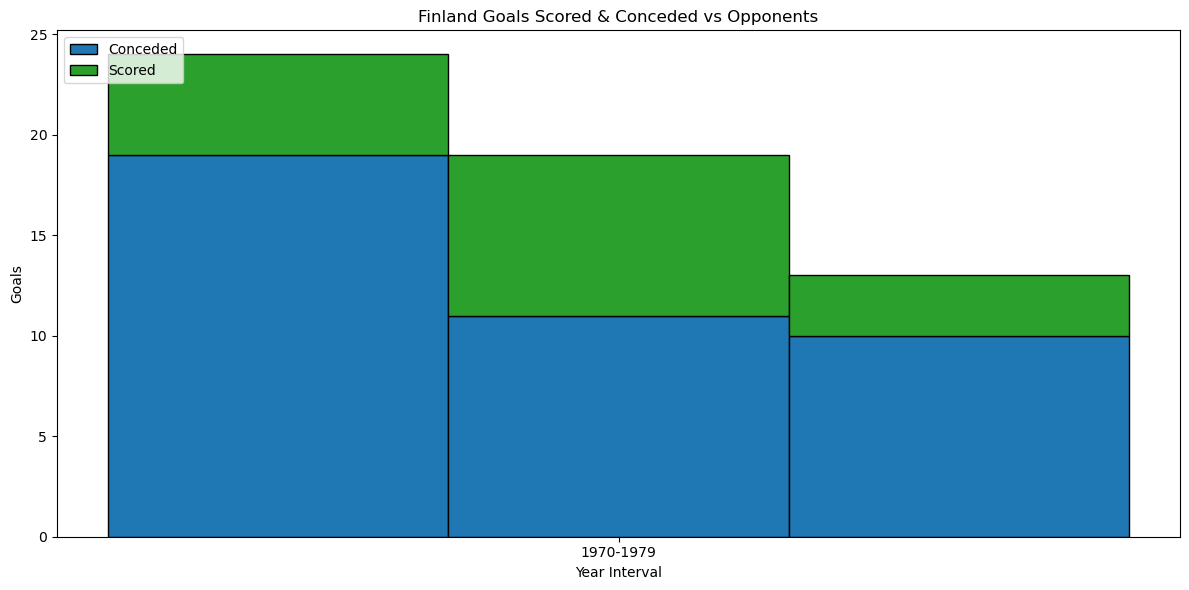


⚽ Goal Stats Analysis for Sweden:

📊 Sweden vs Norway - Goal Summary:


,Year Interval,Opponent,Goals Scored,Goals Conceded,Match Number
0,1970-1979,Norway,21.000000,10.000000,11
1,TOTAL,Norway,21.000000,10.000000,11
2,AVERAGE (per match),Norway,1.910000,0.910000,
3,STD DEV (per match),Norway,0.000000,0.000000,



📊 Sweden vs Denmark - Goal Summary:


,Year Interval,Opponent,Goals Scored,Goals Conceded,Match Number
0,1970-1979,Denmark,16.000000,11.000000,11
1,TOTAL,Denmark,16.000000,11.000000,11
2,AVERAGE (per match),Denmark,1.450000,1.000000,
3,STD DEV (per match),Denmark,0.000000,0.000000,



📊 Sweden vs Finland - Goal Summary:


,Year Interval,Opponent,Goals Scored,Goals Conceded,Match Number
0,1970-1979,Finland,19.000000,5.000000,7
1,TOTAL,Finland,19.000000,5.000000,7
2,AVERAGE (per match),Finland,2.710000,0.710000,
3,STD DEV (per match),Finland,0.000000,0.000000,


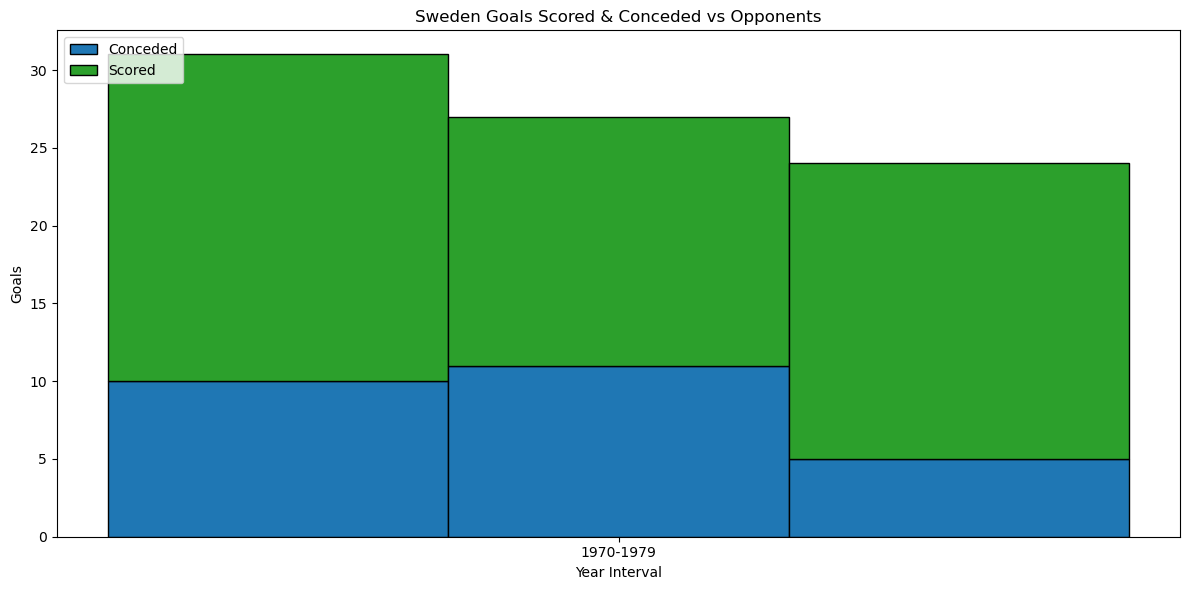

In [67]:
def goal_stats_analysis_with_intervals(df, team_1, opposite_teams, interval, start_year, end_year):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    goal_data = []

    for opponent in opposite_teams:
        for year in range(start_year, end_year + 1, interval):
            end = year + interval - 1
            interval_label = f"{year}-{end}"

            mask = (
                ((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
                ((df['Away_team'] == team_1) & (df['Home_team'] == opponent))
            ) & df['Year'].between(year, end)

            subset = df[mask]

            if subset.empty:
                continue

            goals_scored = 0
            goals_conceded = 0
            match_number = len(subset)

            for _, row in subset.iterrows():
                if row['Home_team'] == team_1:
                    goals_scored += row['home_score']
                    goals_conceded += row['away_score']
                elif row['Away_team'] == team_1:
                    goals_scored += row['away_score']
                    goals_conceded += row['home_score']

            goal_data.append({
                "Year Interval": interval_label,
                "Opponent": opponent,
                "Goals Scored": goals_scored,
                "Goals Conceded": goals_conceded,
                "Match Number": match_number
            })

    return pd.DataFrame(goal_data)

def plot_grouped_stacked_bar(df, team_1, opposite_teams):
    intervals = sorted(df['Year Interval'].unique())
    n_intervals = len(intervals)
    n_opponents = len(opposite_teams)

    bar_width = 0.2
    x = np.arange(n_intervals)
    offsets = np.linspace(-bar_width, bar_width, n_opponents)

    colors = {'Goals Scored': '#2ca02c', 'Goals Conceded': '#1f77b4'}

    fig, ax = plt.subplots(figsize=(12, 6))
    legend_labels = []

    for i, opponent in enumerate(opposite_teams):
        opponent_df = df[df['Opponent'] == opponent].set_index('Year Interval').reindex(intervals).fillna(0)

        scored = opponent_df["Goals Scored"].values
        conceded = opponent_df["Goals Conceded"].values

        x_pos = x + offsets[i]
        ax.bar(x_pos, conceded, width=bar_width, color=colors['Goals Conceded'], edgecolor='black')
        ax.bar(x_pos, scored, width=bar_width, bottom=conceded, color=colors['Goals Scored'], edgecolor='black')

        if i == 0:
            legend_labels.append('Conceded')
            legend_labels.append('Scored')

    ax.set_xticks(x)
    ax.set_xticklabels(intervals)
    ax.set_xlabel('Year Interval')
    ax.set_ylabel('Goals')
    ax.set_title(f'{team_1} Goals Scored & Conceded vs Opponents')

    ax.legend(legend_labels, loc='upper left')
    plt.tight_layout()
    plt.show()

def run_goal_comparison(df, team_1, opposite_teams, interval, start_year, end_year):
    goal_stats = goal_stats_analysis_with_intervals(
        df, team_1=team_1, opposite_teams=opposite_teams,
        interval=interval, start_year=start_year, end_year=end_year
    )

    print(f"\n⚽ Goal Stats Analysis for {team_1}:")

    for opponent in opposite_teams:
        country_goals = goal_stats[goal_stats['Opponent'] == opponent].copy()

        total_scored = country_goals["Goals Scored"].sum()
        total_conceded = country_goals["Goals Conceded"].sum()
        total_matches = country_goals["Match Number"].sum()

        avg_scored = total_scored / total_matches if total_matches else 0
        avg_conceded = total_conceded / total_matches if total_matches else 0

        per_match_scored = []
        per_match_conceded = []

        for _, row in country_goals.iterrows():
            if row["Match Number"] > 0:
                per_match_scored.append(row["Goals Scored"] / row["Match Number"])
                per_match_conceded.append(row["Goals Conceded"] / row["Match Number"])

        std_scored = np.std(per_match_scored) if per_match_scored else 0
        std_conceded = np.std(per_match_conceded) if per_match_conceded else 0

        total_row = {
            "Year Interval": "TOTAL",
            "Opponent": opponent,
            "Goals Scored": total_scored,
            "Goals Conceded": total_conceded,
            "Match Number": total_matches
        }
        avg_row = {
            "Year Interval": "AVERAGE (per match)",
            "Opponent": opponent,
            "Goals Scored": round(avg_scored, 2),
            "Goals Conceded": round(avg_conceded, 2),
            "Match Number": ""
        }
        std_row = {
            "Year Interval": "STD DEV (per match)",
            "Opponent": opponent,
            "Goals Scored": round(std_scored, 2),
            "Goals Conceded": round(std_conceded, 2),
            "Match Number": ""
        }

        stats_df = pd.DataFrame([total_row, avg_row, std_row])
        combined_df = pd.concat([country_goals, stats_df], ignore_index=True)

        styled = combined_df.style.background_gradient(
            subset=["Goals Scored", "Goals Conceded"],
            cmap='Oranges'
        ).set_properties(**{'text-align': 'center'}).set_table_styles(
            [dict(selector='th', props=[('text-align', 'center')])]
        )

        print(f"\n📊 {team_1} vs {opponent} - Goal Summary:")
        display(styled)

    plot_grouped_stacked_bar(goal_stats, team_1, opposite_teams)




df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

# Compare Finland
run_goal_comparison(df, team_1="Finland", opposite_teams=["Sweden", "Norway", "Denmark"], interval=10, start_year=1970, end_year=1979)

# Compare Germany
run_goal_comparison(df, team_1="Sweden", opposite_teams=["Norway", "Denmark", "Finland"], interval=10, start_year=1970, end_year=1979)


Norway 

# Forward or Score by Opponent Teams

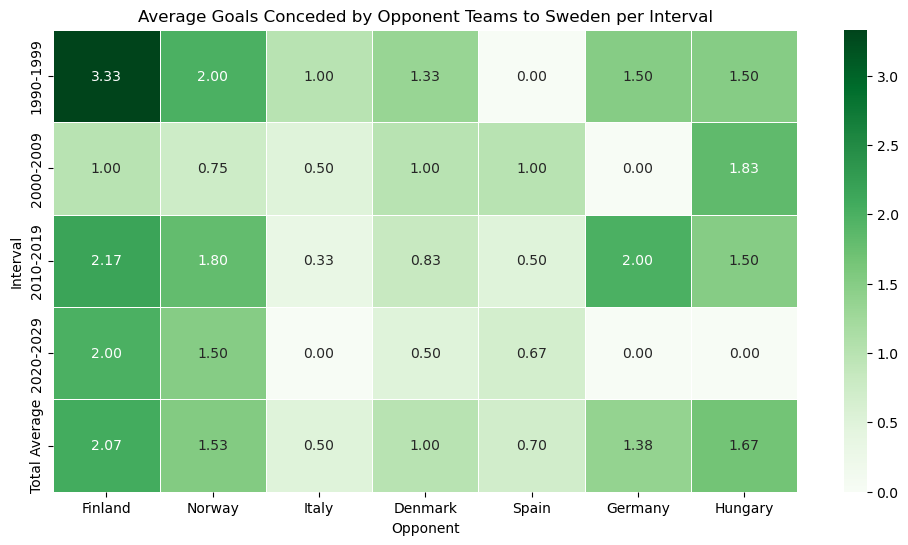

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detailed_opponent_conceded_summary(df, team_1="Sweden", opposite_teams=None,
                                       interval_time=10, start_year=1990, end_year=2022):
    if opposite_teams is None:
        opposite_teams = ["Finland", "Hungary", "Norway", "Germany", "Italy", "Spain"]

    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year

    # Filter matches where team_1 played and opponent is in opposite_teams
    df_filtered = df[
        (df['year'] >= start_year) & (df['year'] <= end_year) &
        ((df['Home_team'] == team_1) | (df['Away_team'] == team_1)) &
        ((df['Home_team'].isin(opposite_teams)) | (df['Away_team'].isin(opposite_teams)))
    ]

    rows = []

    total_conceded_by_opponent = {team: 0 for team in opposite_teams}
    total_matches = {team: 0 for team in opposite_teams}
    goals_by_team1_list = {team: [] for team in opposite_teams}

    for start in range(start_year, end_year + 1, interval_time):
        end = start + interval_time - 1
        interval_df = df_filtered[(df_filtered['year'] >= start) & (df_filtered['year'] <= end)]
        row = {}

        for opponent in opposite_teams:
            conceded_by_opponent = 0
            matches = 0

            # Sweden is home, goals conceded by opponent = Sweden's home_score
            home_matches = interval_df[(interval_df['Home_team'] == team_1) & (interval_df['Away_team'] == opponent)]
            conceded_by_opponent += home_matches['home_score'].sum()
            matches += len(home_matches)
            goals_by_team1_list[opponent].extend(home_matches['home_score'].tolist())

            # Sweden is away, goals conceded by opponent = Sweden's away_score
            away_matches = interval_df[(interval_df['Away_team'] == team_1) & (interval_df['Home_team'] == opponent)]
            conceded_by_opponent += away_matches['away_score'].sum()
            matches += len(away_matches)
            goals_by_team1_list[opponent].extend(away_matches['away_score'].tolist())

            total_conceded_by_opponent[opponent] += conceded_by_opponent
            total_matches[opponent] += matches

            avg = conceded_by_opponent / matches if matches else 0

            row[(opponent, 'Conceded')] = conceded_by_opponent
            row[(opponent, 'Total Match')] = matches
            row[(opponent, 'Avg')] = round(avg, 2)

        rows.append((f"{start}-{end}", row))

    tuples = []
    for opponent in opposite_teams:
        for stat in ['Conceded', 'Total Match', 'Avg']:
            tuples.append((opponent, stat))
    columns = pd.MultiIndex.from_tuples(tuples, names=['Opponent', 'Statistic'])

    index = []
    data = []
    for interval, row in rows:
        index.append(interval)
        data.append(row)

    df_intervals = pd.DataFrame(data, index=index, columns=columns)

    # Summary rows
    total_row = {}
    avg_row = {}
    std_row = {}

    for opponent in opposite_teams:
        total = total_conceded_by_opponent[opponent]
        matches = total_matches[opponent]
        avg = total / matches if matches else 0
        std = round(np.std(goals_by_team1_list[opponent]), 2) if goals_by_team1_list[opponent] else 0

        total_row[(opponent, 'Conceded')] = total
        total_row[(opponent, 'Total Match')] = matches
        total_row[(opponent, 'Avg')] = round(avg, 2)

        avg_row[(opponent, 'Conceded')] = ''
        avg_row[(opponent, 'Total Match')] = ''
        avg_row[(opponent, 'Avg')] = round(avg, 2)

        std_row[(opponent, 'Conceded')] = ''
        std_row[(opponent, 'Total Match')] = ''
        std_row[(opponent, 'Avg')] = std

    df_summary = pd.DataFrame(
        [total_row, avg_row, std_row],
        index=['Total', 'AVG', 'STD'],
        columns=columns
    )

    df_final = pd.concat([df_intervals, df_summary])
    df_final.reset_index(inplace=True)
    df_final.rename(columns={'index': 'Interval'}, inplace=True)

    def highlight_gradients(s):
        is_avg = s.name[1] == 'Avg'
        if not is_avg:
            return ['' for _ in s]
        result = []
        for idx, val in enumerate(s):
            if s.index[idx] in ['Total', 'AVG', 'STD']:
                result.append('')
            else:
                try:
                    num = float(val)
                    if num > 0:
                        result.append('background-color: #a6d96a')  # greenish for scored/conceded by opponent
                    else:
                        result.append('')
                except:
                    result.append('')
        return result

    styled = df_final.style
    styled = styled.apply(highlight_gradients, subset=pd.IndexSlice[:, pd.IndexSlice[:, 'Avg']])
    styled = styled.format(precision=2, na_rep='')

    return styled, df_final

def plot_avg_conceded_heatmap(df_final, opposite_teams):
    interval_df = df_final[~df_final['Interval'].isin(['Total', 'AVG', 'STD'])].copy()

    avg_cols = [(team, 'Avg') for team in opposite_teams]
    heatmap_data = interval_df.set_index('Interval')[avg_cols]
    heatmap_data.columns = [team for team, stat in avg_cols]

    total_row = df_final[df_final['Interval'] == 'Total']
    total_avgs = {}
    for team in opposite_teams:
        total_conceded = total_row[(team, 'Conceded')].values[0]
        total_matches = total_row[(team, 'Total Match')].values[0]
        total_avg = total_conceded / total_matches if total_matches else 0
        total_avgs[team] = total_avg

    total_avg_df = pd.DataFrame(total_avgs, index=['Total Average'])
    heatmap_data = pd.concat([heatmap_data, total_avg_df])

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='Greens', fmt=".2f", linewidths=0.5)
    plt.title(f"Average Goals Conceded by Opponent Teams to {team_1} per Interval")
    plt.ylabel("Interval")
    plt.xlabel("Opponent")
    plt.show()

# Usage example:
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

styled_table, df_final = detailed_opponent_conceded_summary(
    df,
    team_1="Sweden",
    opposite_teams=["Finland", "Norway", "Italy", "Denmark", "Spain", "Germany", "Hungary"],
    interval_time=10,
    start_year=1990,
    end_year=2024
)

display(styled_table)
plot_avg_conceded_heatmap(df_final, ["Finland", "Norway", "Italy", "Denmark", "Spain", "Germany", "Hungary"])


Line Chart


📈 Line Chart Comparison for Finland:


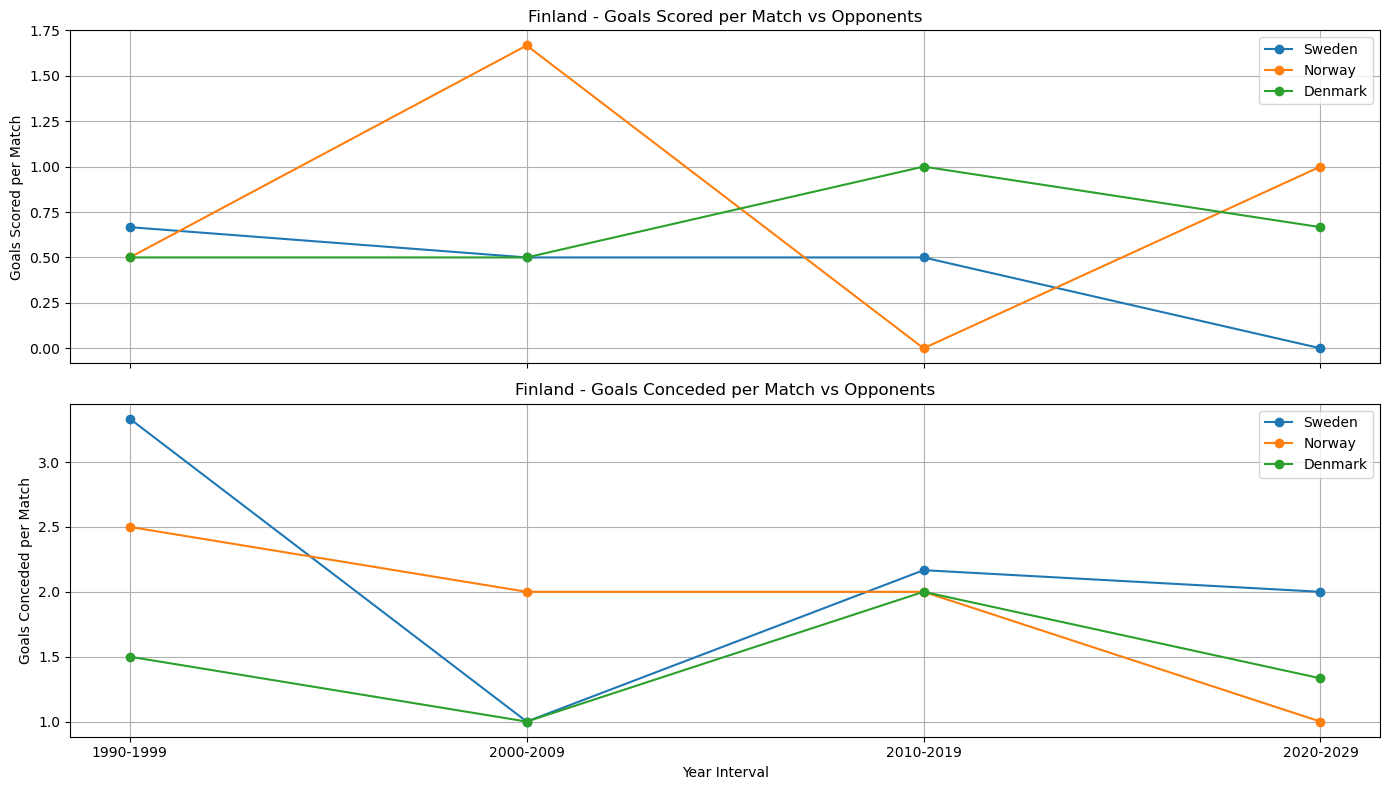


📈 Line Chart Comparison for Sweden:


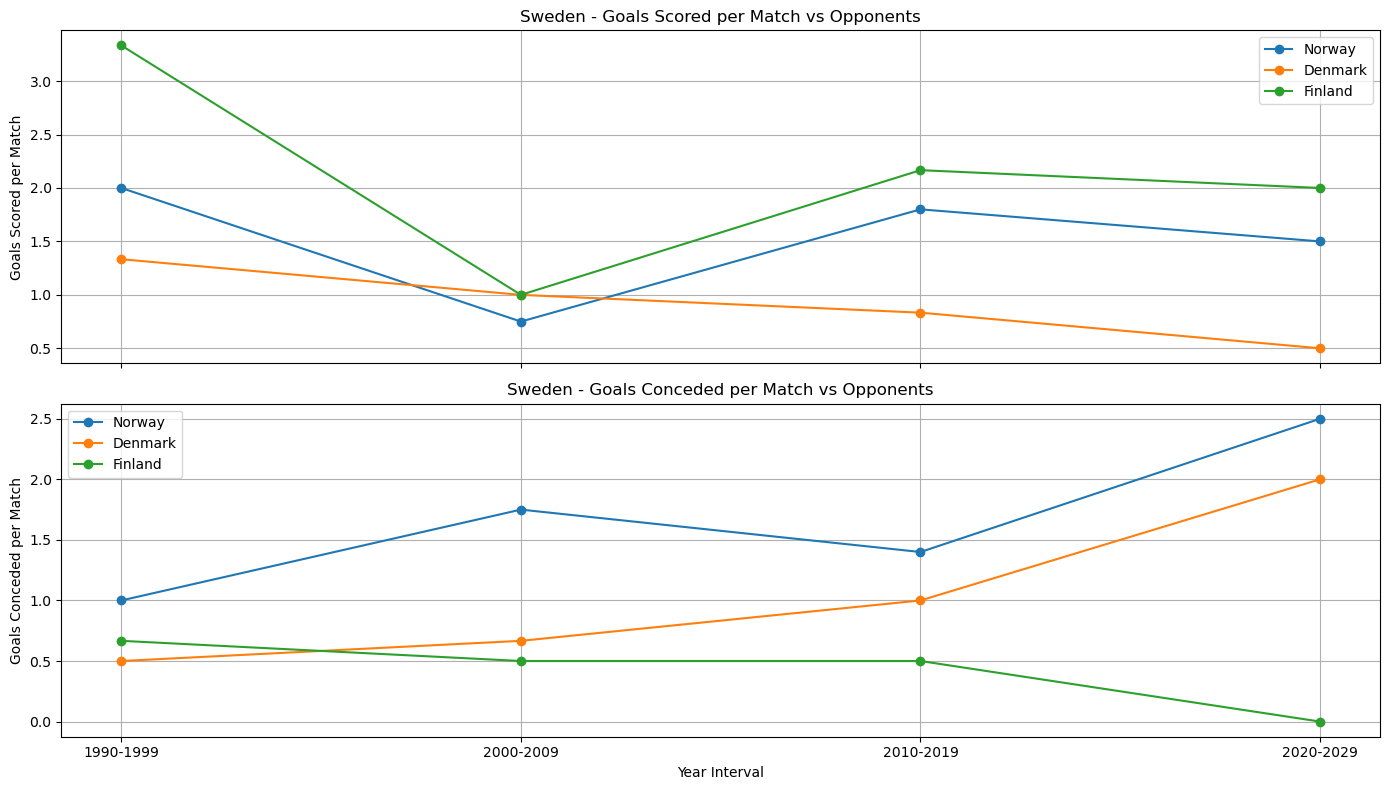

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display as ipy_display

def safe_display(obj):
    try:
        ipy_display(obj)
    except:
        print(obj)

def goal_stats_analysis_with_intervals(df, team_1, opposite_teams, interval, start_year, end_year):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    goal_data = []

    for opponent in opposite_teams:
        for year in range(start_year, end_year + 1, interval):
            end = year + interval - 1
            interval_label = f"{year}-{end}"

            mask = (
                ((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
                ((df['Away_team'] == team_1) & (df['Home_team'] == opponent))
            ) & df['Year'].between(year, end)

            subset = df[mask]

            if subset.empty:
                continue

            goals_scored = 0
            goals_conceded = 0
            match_number = len(subset)

            for _, row in subset.iterrows():
                if row['Home_team'] == team_1:
                    goals_scored += row['home_score']
                    goals_conceded += row['away_score']
                elif row['Away_team'] == team_1:
                    goals_scored += row['away_score']
                    goals_conceded += row['home_score']

            per_match_scored = goals_scored / match_number
            per_match_conceded = goals_conceded / match_number

            goal_data.append({
                "Year Interval": interval_label,
                "Opponent": opponent,
                "Goals Scored per Match": per_match_scored,
                "Goals Conceded per Match": per_match_conceded,
            })

    return pd.DataFrame(goal_data)

def plot_line_chart(df, team_1, opposite_teams):
    intervals = sorted(df['Year Interval'].unique(), key=lambda x: int(x.split('-')[0]))

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    for opponent in opposite_teams:
        opp_df = df[df['Opponent'] == opponent].set_index('Year Interval').reindex(intervals).fillna(0)
        axs[0].plot(intervals, opp_df["Goals Scored per Match"], marker='o', label=opponent)
        axs[1].plot(intervals, opp_df["Goals Conceded per Match"], marker='o', label=opponent)

    axs[0].set_title(f'{team_1} - Goals Scored per Match vs Opponents')
    axs[0].set_ylabel('Goals Scored per Match')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title(f'{team_1} - Goals Conceded per Match vs Opponents')
    axs[1].set_ylabel('Goals Conceded per Match')
    axs[1].set_xlabel('Year Interval')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def run_goal_comparison_line_plot(df, team_1, opposite_teams, interval, start_year, end_year):
    goal_stats = goal_stats_analysis_with_intervals(
        df, team_1=team_1, opposite_teams=opposite_teams,
        interval=interval, start_year=start_year, end_year=end_year
    )

    print(f"\n📈 Line Chart Comparison for {team_1}:")
    plot_line_chart(goal_stats, team_1, opposite_teams)

# Load the dataset
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

# Example usage for Finland
run_goal_comparison_line_plot(df, team_1="Finland", opposite_teams=["Sweden", "Norway", "Denmark"], interval=10, start_year=1990, end_year=2024)

# Example usage for Sweden
run_goal_comparison_line_plot(df, team_1="Sweden", opposite_teams=["Norway", "Denmark", "Finland"], interval=10, start_year=1990, end_year=2024)


<h5 style="line-height:2rem;">
Finland scored the most goals against Norway and Denmark. Sweden scored the most against Finland and let in the most goals against Norway.

Sweden scored more goals against Finland than against Denmark and Norway. Sweden scored the fewest goals against Denmark, suggesting Denmark has a better defense than Finland and Norway.

Finland let in the fewest goals against Sweden, while Norway scored the most against Sweden, suggesting Norway has a better attack than Finland and Denmark.

</h5>


Max Min Scale

5. Heatmaps
Rows: Opponents

Columns: Intervals

Color intensity represents values (e.g., goals scored per match).

Use separate heatmaps for scored and conceded or combined with diverging color map.


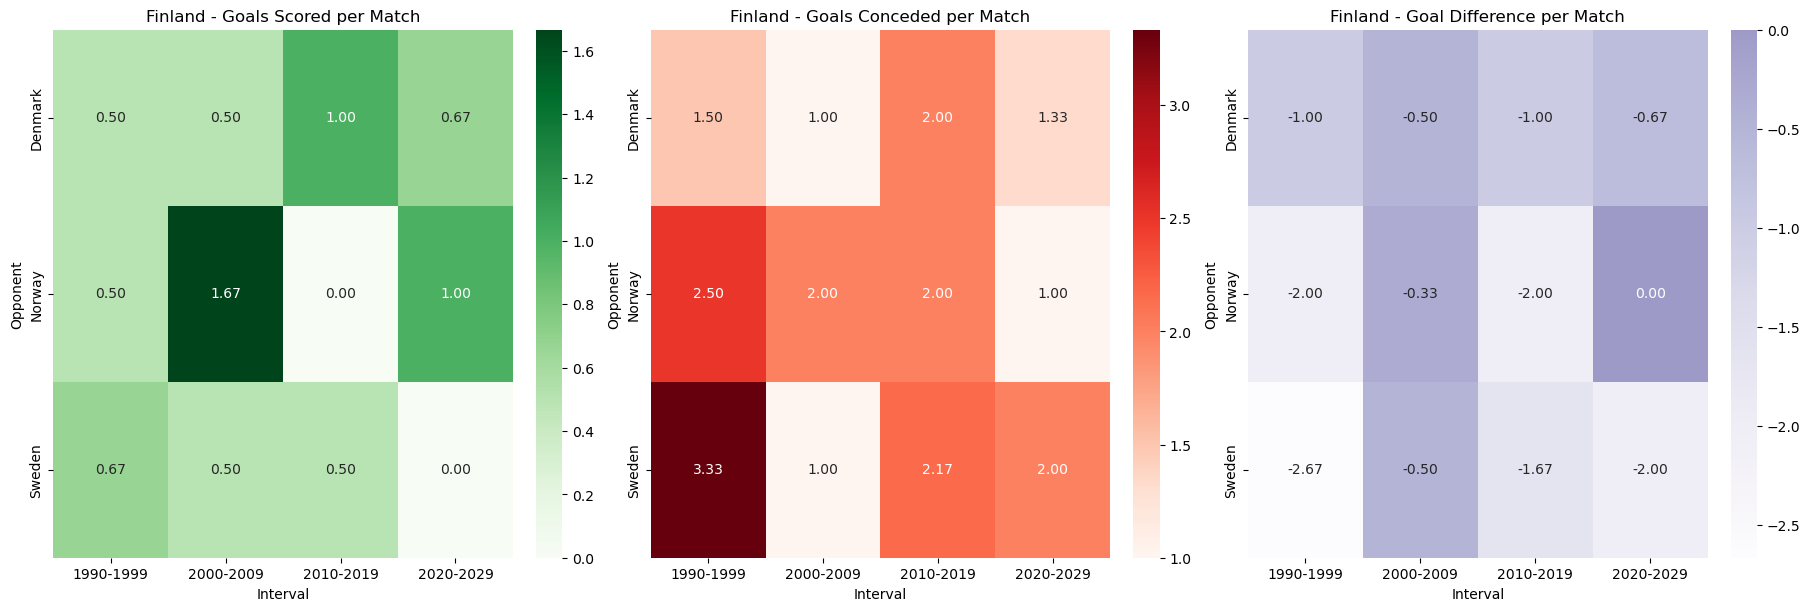

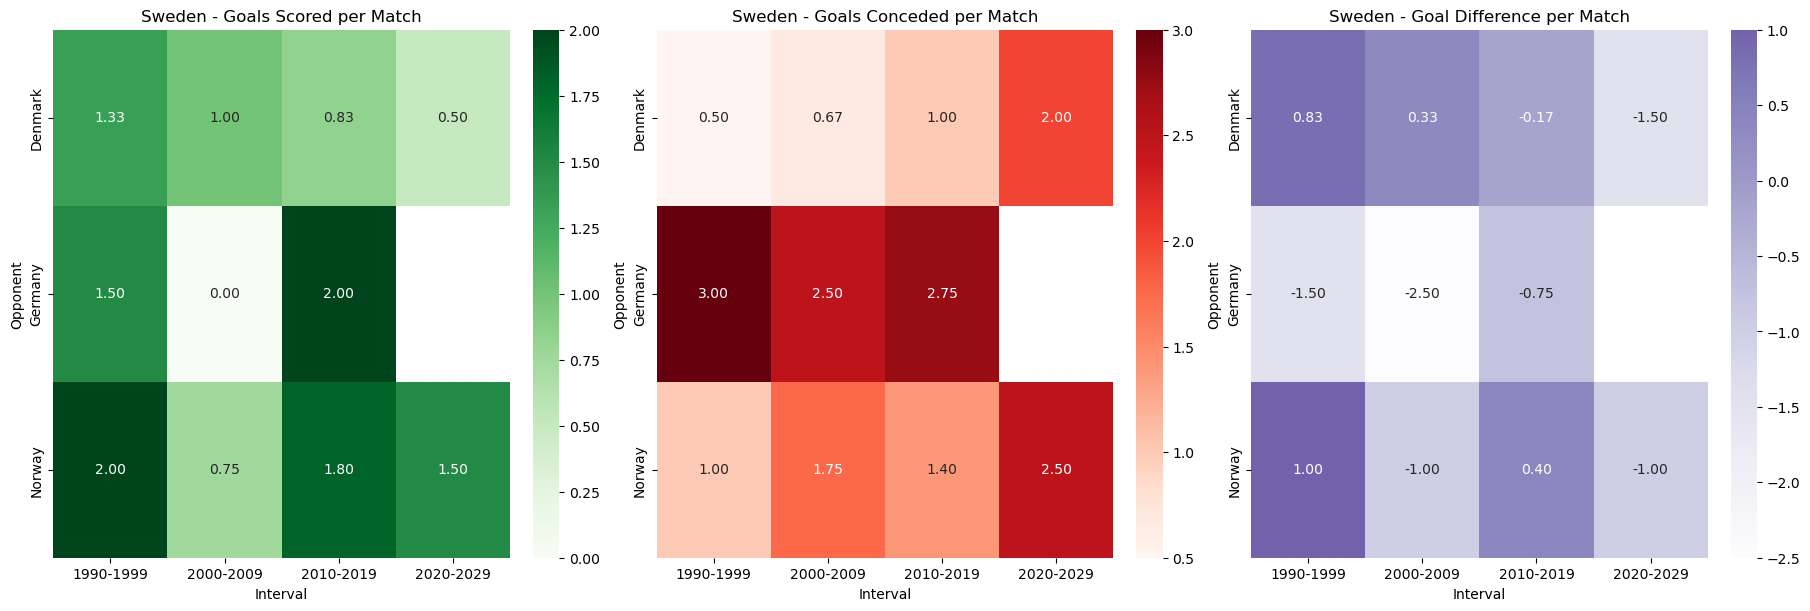

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_heatmap_data(df, team_1, opposite_teams, interval, start_year, end_year):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    records = []

    for opponent in opposite_teams:
        for year in range(start_year, end_year + 1, interval):
            end = year + interval - 1
            label = f"{year}-{end}"

            mask = (
                ((df['Home_team'] == team_1) & (df['Away_team'] == opponent)) |
                ((df['Away_team'] == team_1) & (df['Home_team'] == opponent))
            ) & df['Year'].between(year, end)

            subset = df[mask]
            if subset.empty:
                continue

            scored = conceded = 0
            matches = len(subset)

            for _, row in subset.iterrows():
                if row['Home_team'] == team_1:
                    scored += row['home_score']
                    conceded += row['away_score']
                else:
                    scored += row['away_score']
                    conceded += row['home_score']

            per_match_scored = scored / matches
            per_match_conceded = conceded / matches

            records.append({
                'Opponent': opponent,
                'Interval': label,
                'Scored per Match': per_match_scored,
                'Conceded per Match': per_match_conceded,
                'Diff per Match': per_match_scored - per_match_conceded
            })

    return pd.DataFrame(records)

def plot_goal_heatmaps(heatmap_df, team_1):
    pivot_scored = heatmap_df.pivot(index='Opponent', columns='Interval', values='Scored per Match')
    pivot_conceded = heatmap_df.pivot(index='Opponent', columns='Interval', values='Conceded per Match')
    pivot_diff = heatmap_df.pivot(index='Opponent', columns='Interval', values='Diff per Match')

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    sns.heatmap(pivot_scored, cmap='Greens', annot=True, fmt=".2f", ax=axs[0])
    axs[0].set_title(f"{team_1} - Goals Scored per Match")

    sns.heatmap(pivot_conceded, cmap='Reds', annot=True, fmt=".2f", ax=axs[1])
    axs[1].set_title(f"{team_1} - Goals Conceded per Match")

    sns.heatmap(pivot_diff, cmap='Purples', center=0, annot=True, fmt=".2f", ax=axs[2])
    axs[2].set_title(f"{team_1} - Goal Difference per Match")

    plt.show()

def run_heatmap_analysis(df, team_1, opposite_teams, interval, start_year, end_year):
    heatmap_df = compute_heatmap_data(df, team_1, opposite_teams, interval, start_year, end_year)
    plot_goal_heatmaps(heatmap_df, team_1)

# Load dataset
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

# Example 1: Finland
run_heatmap_analysis(df, team_1="Finland", opposite_teams=["Sweden", "Norway", "Denmark"], interval=10, start_year=1990, end_year=2024)

# Example 2: Sweden
run_heatmap_analysis(df, team_1="Sweden", opposite_teams=["Norway", "Denmark", "Germany"], interval=10, start_year=1990, end_year=2024)


In [121]:
import pandas as pd

# Load dataset
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

# Clean and convert date
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

def most_played_opponents_matrix(df, teams, start_year=1990, end_year=2022):
    # Filter by year
    df_filtered = df[df['Year'].between(start_year, end_year)]

    # Build pair-wise match count dictionary
    match_counts = {}

    for team_1 in teams:
        match_counts[team_1] = {}
        for team_2 in teams:
            if team_1 == team_2:
                match_counts[team_1][team_2] = 0  # A team can't play itself
                continue

            # Count matches regardless of home/away order
            matches = df_filtered[
                ((df_filtered['Home_team'] == team_1) & (df_filtered['Away_team'] == team_2)) |
                ((df_filtered['Home_team'] == team_2) & (df_filtered['Away_team'] == team_1))
            ]
            match_counts[team_1][team_2] = len(matches)

    # Convert to DataFrame
    matrix_df = pd.DataFrame(match_counts).T  # Transpose for teams as rows
    return matrix_df

# Teams to compare
teams = ["Finland", "Norway", "Sweden", "Denmark", "Germany", "Hungary", "Estonia", "Turkey", 
         "Greece", "Italy", "France", "Netherlands", "Poland", 
         "Austria", "Spain", "Portugal"]

# Build and display the accurate matrix
result_matrix = most_played_opponents_matrix(df, teams, start_year=1990, end_year=2022)

# Style with heatmap
styled = result_matrix.style.background_gradient(cmap="Blues")
styled


,Finland,Norway,Sweden,Denmark,Germany,Hungary,Estonia,Turkey,Greece,Italy,France,Netherlands,Poland,Austria,Spain,Portugal
Finland,0,7,14,6,8,10,15,10,14,7,9,6,10,4,5,7
Norway,7,0,15,9,4,9,5,8,7,10,4,9,6,4,7,6
Sweden,14,15,0,19,8,12,6,10,6,8,13,7,10,13,10,9
Denmark,6,9,19,0,10,4,1,7,5,6,13,8,7,8,8,10
Germany,8,4,8,10,0,8,2,8,3,15,14,16,8,11,11,10
Hungary,10,9,12,4,8,0,6,9,11,8,3,6,9,8,2,8
Estonia,15,5,6,1,2,6,0,7,6,7,1,6,6,2,2,8
Turkey,10,8,10,7,8,9,7,0,6,6,6,12,4,7,3,5
Greece,14,7,6,5,3,11,6,6,0,4,3,4,7,6,7,9
Italy,7,10,8,6,15,8,7,6,4,0,11,13,8,5,17,10


K Means

In [87]:
print(ax.elev, ax.azim)


25 135


,Team,Avg Goals Scored,Avg Goals Conceded,Win Rate,Cluster
16,Finland,1.183594,1.171875,0.382812,0
30,India,1.412935,1.502488,0.398010,0
28,Bahrain,1.355191,1.122951,0.393443,0
25,Jordan,1.310976,0.963415,0.390244,0
22,United Arab Emirates,1.483974,1.214744,0.403846,0
21,Oman,1.444444,0.987988,0.453453,0
20,Honduras,1.440000,1.249231,0.390769,0
17,Kuwait,1.431438,1.187291,0.361204,0
15,Chile,1.332203,1.196610,0.416949,0
14,Uganda,1.241497,0.911565,0.404762,0


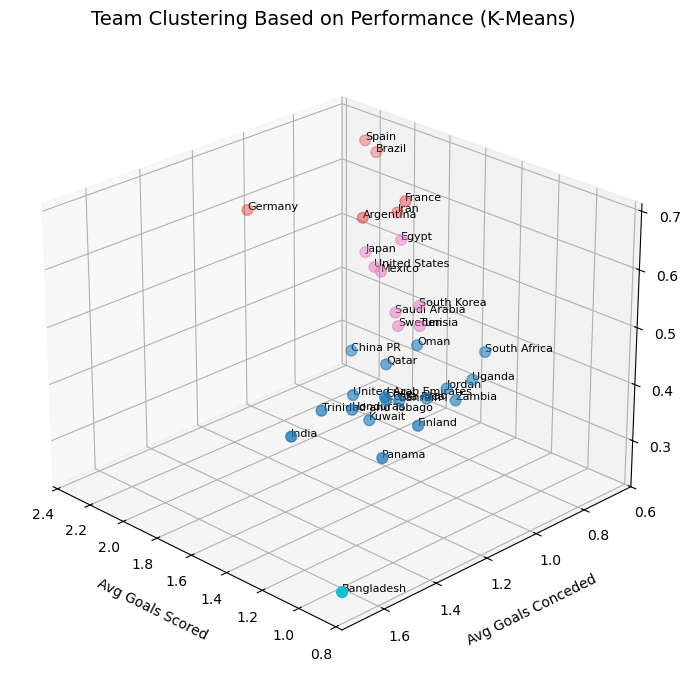

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

def cluster_team_by_performance(df, top_n=60, start_year=2000, end_year=2022,
                                 include_team=None, team_list=None, n_clusters=4):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df = df[df['Year'].between(start_year, end_year)]

    all_teams = pd.unique(df[['Home_team', 'Away_team']].values.ravel())
    stats = []

    for team in all_teams:
        team_matches = df[(df['Home_team'] == team) | (df['Away_team'] == team)]
        if team_matches.empty:
            continue

        goals_scored = 0
        goals_conceded = 0
        wins = 0
        matches = len(team_matches)

        for _, row in team_matches.iterrows():
            if row['Home_team'] == team:
                goals_scored += row['home_score']
                goals_conceded += row['away_score']
                if row['home_score'] > row['away_score']:
                    wins += 1
            else:
                goals_scored += row['away_score']
                goals_conceded += row['home_score']
                if row['away_score'] > row['home_score']:
                    wins += 1

        stats.append({
            'Team': team,
            'Avg Goals Scored': goals_scored / matches,
            'Avg Goals Conceded': goals_conceded / matches,
            'Win Rate': wins / matches,
            'Matches': matches
        })

    df_stats = pd.DataFrame(stats)

    # Filter logic: use team_list or top_n
    if team_list:
        selected_teams = set(team_list)
    else:
        selected_teams = set(df_stats.sort_values(by='Matches', ascending=False).head(top_n)['Team'])

    if include_team:
        selected_teams.update(include_team)

    df_stats = df_stats[df_stats['Team'].isin(selected_teams)].reset_index(drop=True)

    # Normalize for clustering
    features = df_stats[['Avg Goals Scored', 'Avg Goals Conceded', 'Win Rate']]
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(features)

    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_stats['Cluster'] = kmeans.fit_predict(normalized)

    # Gradient-style display
    styled_df = df_stats[['Team', 'Avg Goals Scored', 'Avg Goals Conceded', 'Win Rate', 'Cluster']].sort_values(by='Cluster')
    display(styled_df.style.background_gradient(cmap='coolwarm', subset=['Avg Goals Scored', 'Avg Goals Conceded', 'Win Rate']))

    # 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        df_stats['Avg Goals Scored'], df_stats['Avg Goals Conceded'], df_stats['Win Rate'],
        c=df_stats['Cluster'], cmap='tab10', s=60
    )

    for _, row in df_stats.iterrows():
        ax.text(row['Avg Goals Scored'], row['Avg Goals Conceded'], row['Win Rate'], row['Team'],
                size=8, zorder=1, color='black')

    ax.set_xlabel('Avg Goals Scored', labelpad=10)
    ax.set_ylabel('Avg Goals Conceded', labelpad=10)
    ax.set_zlabel('Win Rate', labelpad=10)
    ax.set_title('Team Clustering Based on Performance (K-Means)', fontsize=14)
    ax.view_init(elev=25, azim=135)
    plt.tight_layout()
    plt.show()




teams = [
    "Finland", "Norway", "Sweden", "Germany", "Hungary", "Estonia", "Turkey", 
    "Greece", "Italy", "France", "Netherlands", "Malta", "Poland", "Brazil", 
    "Austria", "Spain", "Portugal", "Morocco", "Argentina", "Israel", "Bangladesh"
]

df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")
cluster_team_by_performance(df, start_year=2000, end_year=2022, include_team=['Finland', 'Bangladesh', 'India'], top_n = 30)


In [209]:
import pandas as pd

df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

def get_result(match_number=10, start_year=2000, end_year=2024, team_1="Germany", team_2="France"):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter by year and teams
    filtered_df = df[(df['Date'].dt.year >= start_year) & (df['Date'].dt.year <= end_year)]
    mask = (
        ((filtered_df['Home_team'] == team_1) & (filtered_df['Away_team'] == team_2)) |
        ((filtered_df['Home_team'] == team_2) & (filtered_df['Away_team'] == team_1))
    )
    filtered_df = filtered_df[mask].sort_values(by='Date', ascending=False).copy()
    
    def match_result(row):
        if row['Home_team'] == team_1:
            if row['home_score'] > row['away_score']:
                return "Win"
            elif row['home_score'] < row['away_score']:
                return "Lost"
            else:
                return "Tie"
        else:
            if row['away_score'] > row['home_score']:
                return "Win"
            elif row['away_score'] < row['home_score']:
                return "Lost"
            else:
                return "Tie"
    
    filtered_df['Match_result'] = filtered_df.apply(match_result, axis=1)
    filtered_df['Date'] = filtered_df['Date'].dt.strftime('%Y-%m-%d')
    
    # Last matches table
    last_matches = filtered_df.head(match_number)
    display_df = last_matches[['Date', 'Home_team', 'Away_team', 'home_score', 'away_score', 'venue_country', 'Match_result']]
    
    styled_last_matches = (display_df.style
              .background_gradient(subset=['home_score', 'away_score'], cmap='YlGnBu')
              .set_properties(subset=['Date'], **{'font-weight': 'bold', 'color': '#2a3f5f'})
              .set_table_styles([
                  {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', '#333'), ('font-weight', 'bold')]},
                  {'selector': 'td', 'props': [('padding', '8px')]},
              ]))
    
    # Overall summary for both teams
    def team_stats(team):
        total = len(filtered_df)
        wins = 0
        for _, row in filtered_df.iterrows():
            if row['Home_team'] == team:
                if row['home_score'] > row['away_score']:
                    wins += 1
            elif row['Away_team'] == team:
                if row['away_score'] > row['home_score']:
                    wins += 1
        return total, wins
    
    total_1, wins_1 = team_stats(team_1)
    total_2, wins_2 = team_stats(team_2)
    
    win_pct_1 = round((wins_1 / total_1) * 100, 2) if total_1 > 0 else 0
    win_pct_2 = round((wins_2 / total_2) * 100, 2) if total_2 > 0 else 0
    
    summary_df = pd.DataFrame({
        'Team': [team_1, team_2],
        'Total Matches': [total_1, total_2],
        'Wins': [wins_1, wins_2],
        'Win Percentage (%)': [win_pct_1, win_pct_2]
    })
    
    styled_summary = (summary_df.style
                      .background_gradient(subset=['Win Percentage (%)'], cmap='Greens')
                      .set_table_styles([
                          {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', '#333'), ('font-weight', 'bold')]},
                          {'selector': 'td', 'props': [('padding', '8px')]},
                      ]))
    
    # Venue country summary with win percentages for both teams
    venue_stats = []
    for venue in filtered_df['venue_country'].unique():
        venue_df = filtered_df[filtered_df['venue_country'] == venue]
        
        def venue_team_wins(team):
            wins = 0
            matches = len(venue_df)
            for _, row in venue_df.iterrows():
                if row['Home_team'] == team and row['home_score'] > row['away_score']:
                    wins += 1
                elif row['Away_team'] == team and row['away_score'] > row['home_score']:
                    wins += 1
            return matches, wins
        
        matches_1, wins_1 = venue_team_wins(team_1)
        matches_2, wins_2 = venue_team_wins(team_2)
        
        win_pct_1 = round((wins_1 / matches_1) * 100, 2) if matches_1 > 0 else 0
        win_pct_2 = round((wins_2 / matches_2) * 100, 2) if matches_2 > 0 else 0
        
        venue_stats.append({
            'Venue Country': venue,
            f'{team_1} Matches': matches_1,
            f'{team_1} Wins': wins_1,
            f'{team_1} Win %': win_pct_1,
            f'{team_2} Matches': matches_2,
            f'{team_2} Wins': wins_2,
            f'{team_2} Win %': win_pct_2,
        })
    
    venue_df = pd.DataFrame(venue_stats)
    
    styled_venue = (venue_df.style
                    .background_gradient(subset=[f'{team_1} Win %', f'{team_2} Win %'], cmap='Greens')
                    .set_table_styles([
                        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', '#333'), ('font-weight', 'bold')]},
                        {'selector': 'td', 'props': [('padding', '8px')]},
                    ]))
    
    return styled_last_matches, styled_summary, styled_venue

# Usage:
last_matches_table, summary_table, venue_table = get_result(10, 2000, 2024, "Germany", "France")

# In Jupyter notebook:
display(last_matches_table)
display(summary_table)
display(venue_table)


,Date,Home_team,Away_team,home_score,away_score,venue_country,Match_result
47070,2024-03-23,France,Germany,0,2,France,Win
46426,2023-09-12,Germany,France,2,1,Germany,Win
44120,2021-06-15,Germany,France,0,1,Germany,Lost
41962,2018-10-16,France,Germany,2,1,France,Lost
41711,2018-09-06,Germany,France,0,0,Germany,Tie
41181,2017-11-14,Germany,France,2,2,Germany,Tie
39933,2016-07-07,France,Germany,2,0,France,Lost
39300,2015-11-13,France,Germany,2,0,France,Lost
37905,2014-07-04,France,Germany,0,1,Brazil,Win
36692,2013-02-06,France,Germany,1,2,France,Win


,Team,Total Matches,Wins,Win Percentage (%)
0,Germany,14,4,28.570000
1,France,14,7,50.000000


,Venue Country,Germany Matches,Germany Wins,Germany Win %,France Matches,France Wins,France Win %
0,France,7,2,28.570000,7,4,57.140000
1,Germany,6,1,16.670000,6,3,50.000000
2,Brazil,1,1,100.000000,1,0,0.000000


In [5]:
import pandas as pd
import numpy as np

def get_goal_diff(df, start_year=1900, end_year=2024, team_1="France", team_2="Germany"):
    # Convert date column and extract year
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Date'] = df['Date'].dt.strftime('%d-%m-%Y')

    # Filter for team vs team in year range
    filtered = df[
        (((df['Home_team'] == team_1) & (df['Away_team'] == team_2)) |
         ((df['Home_team'] == team_2) & (df['Away_team'] == team_1))) &
        (df['Year'] >= start_year) & (df['Year'] <= end_year)
    ].copy()

    if filtered.empty:
        print("⚠️ No matches found in the specified range.")
        return pd.DataFrame()

    # Extract team-specific goals
    def get_goals(row, team):
        if row['Home_team'] == team:
            return row['home_score']
        elif row['Away_team'] == team:
            return row['away_score']
        return None

    filtered[f'{team_1}_goals'] = filtered.apply(lambda row: get_goals(row, team_1), axis=1)
    filtered[f'{team_2}_goals'] = filtered.apply(lambda row: get_goals(row, team_2), axis=1)

    filtered.dropna(subset=[f'{team_1}_goals', f'{team_2}_goals'], inplace=True)

    # Goal difference (team_1 perspective)
    filtered['goal_diff'] = filtered[f'{team_1}_goals'] - filtered[f'{team_2}_goals']

    # Win/Draw counts
    win_counts = {
        team_1: sum(filtered['goal_diff'] > 0),
        team_2: sum(filtered['goal_diff'] < 0),
        "Draw": sum(filtered['goal_diff'] == 0)
    }

    print("\n✅ Win/Draw Counts:")
    print(win_counts)

    # Add summary rows
    total_matches = len(filtered)
    total_scored = filtered[f'{team_1}_goals'].sum()
    total_conceded = filtered[f'{team_2}_goals'].sum()
    avg_scored = round(total_scored / total_matches, 2)
    avg_conceded = round(total_conceded / total_matches, 2)
    std_scored = round(filtered[f'{team_1}_goals'].std(), 2)
    std_conceded = round(filtered[f'{team_2}_goals'].std(), 2)

    # Build final result DataFrame
    result_df = filtered[['Date', f'{team_1}_goals', f'{team_2}_goals', 'goal_diff']].copy()

    # Append summary rows
    summary_rows = pd.DataFrame([
        {"Date": "TOTAL", f'{team_1}_goals': total_scored, f'{team_2}_goals': total_conceded, 'goal_diff': total_scored - total_conceded},
        {"Date": "AVERAGE", f'{team_1}_goals': avg_scored, f'{team_2}_goals': avg_conceded, 'goal_diff': round(avg_scored - avg_conceded, 2)},
        {"Date": "STD DEV", f'{team_1}_goals': std_scored, f'{team_2}_goals': std_conceded, 'goal_diff': round(std_scored - std_conceded, 2)},
    ])

    result_df = pd.concat([result_df, summary_rows], ignore_index=True)

    # Apply gradient styling
    styled = (
        result_df.style
        .background_gradient(subset=[f'{team_1}_goals', f'{team_2}_goals', 'goal_diff'], cmap='YlGnBu')
        .set_properties(**{'font-family': 'monospace', 'font-size': '12px'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]}
        ])
    )

    return styled


# Load data
df = pd.read_csv("Datasets/Sports_Football_1872_2025.csv")

# Example usage
get_goal_diff(df, start_year=1970, end_year=2024, team_1="Sweden", team_2="Finland")



✅ Win/Draw Counts:
{'Sweden': 22, 'Finland': 5, 'Draw': 3}


,Date,Sweden_goals,Finland_goals,goal_diff
0,26-08-1970,2.000000,1.000000,1.000000
1,20-05-1971,4.000000,1.000000,3.000000
2,08-07-1973,1.000000,1.000000,0.000000
3,29-08-1973,2.000000,1.000000,1.000000
4,01-06-1976,2.000000,0.000000,2.000000
5,11-08-1976,6.000000,0.000000,6.000000
6,28-06-1978,2.000000,1.000000,1.000000
7,22-05-1980,2.000000,0.000000,2.000000
8,01-03-1981,1.000000,2.000000,-1.000000
9,29-07-1981,1.000000,0.000000,1.000000
